In [1]:
import pandas as pd
import numpy as np
import os
import math

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

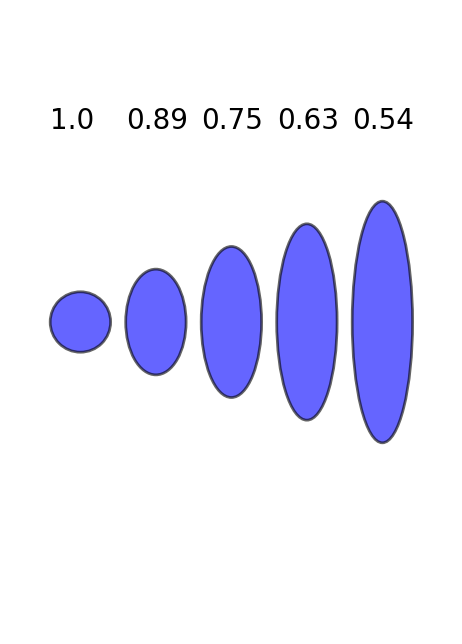

In [2]:
## simulate some ellipses

from matplotlib.patches import Ellipse

num = 5

def calculate_perimeter(a,b):
    perimeter = math.pi * ( 3*(a+b) - math.sqrt( (3*a + b) * (a + 3*b) ) )
    return perimeter

def get_circ(h, w):
    A = math.pi * h * w
    P = calculate_perimeter(h, w)
    circ = 4*math.pi*(A/P**2)
    return circ

x = np.linspace(1, num + 1, num)
y = np.array([5] * num)

xy = np.column_stack((x,y))

height = np.linspace(1, 4, num)
width = np.array([1] * num)

circs = []

for h, w in zip(height, width):
    c = get_circ(h, w)
    circs.append(c)

ells = []
    
for _xy, _h, _w, in zip(xy, height, width):
    e = Ellipse(xy=_xy, width=_w, height=_h) 
    ells.append(e)
    
            
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 4
fig = plt.figure(0)
ax = fig.add_subplot(111, aspect='equal')
for e in ells:
    ax.add_artist(e)
    e.set_clip_box(ax.bbox)
    e.set_alpha(0.6)
    e.set_facecolor('b')
    e.set_edgecolor('k')

ax.set_xlim(0, num+2)
ax.set_ylim(0, 10)

for _xy, c in zip(xy, circs):
    
    _x = _xy[0] - 0.5
    _y = _xy[1] + 3.2
    plt.text(_x, _y , str(round(c, 2)))

plt.axis("off")
    
plt.show()



In [3]:
root_dir = "/nfs/turbo/umms-indikar/shared/projects/live_cell_imaging/6A/subset_outputs/"

experiments = {
    "B3" : "PRAX1",
    "B5" : "Control",
    "D5" : "MyoD",
    "C2" : "Twist2"
}

df_list = []

for _dir, condition in experiments.items():
    file_path  =f"{root_dir}{_dir}/Cell Count Summary Blue.csv"
    tmp = pd.read_csv(file_path)
    
    tmp['Scene'] = _dir
    tmp['Condition'] = condition
    tmp['Frame'] = tmp.index + 1
    tmp['Delta'] = tmp['Count'].diff()
    
    monotonic_growth = []
    
    count = 0
    for c in tmp['Count']:
        if c > count:
            count = c
        monotonic_growth.append(count)
        
    tmp['Monotonic Growth'] = monotonic_growth
    
    df_list.append(tmp)
    
df = pd.concat(df_list, ignore_index=True)
df.head()

,Slice,Count,Total Area,Average Size,%Area,Mean,Major,Minor,Angle,Scene,Condition,Frame,Delta,Monotonic Growth
0,c:2/4 t:1/102 - B3_subset.czi #1,221,51128.843,231.352,5.014,255,20.993,13.557,98.269,B3,PRAX1,1,NaN,221
1,c:2/4 t:2/102 - B3_subset.czi #1,212,49767.952,234.754,4.881,255,21.309,13.596,97.451,B3,PRAX1,2,-9.0,221
2,c:2/4 t:3/102 - B3_subset.czi #1,225,51305.840,228.026,5.031,255,21.038,13.382,97.196,B3,PRAX1,3,13.0,225
3,c:2/4 t:4/102 - B3_subset.czi #1,225,52519.412,233.420,5.150,255,21.341,13.471,93.436,B3,PRAX1,4,0.0,225
4,c:2/4 t:5/102 - B3_subset.czi #1,224,51578.488,230.261,5.058,255,21.094,13.449,91.697,B3,PRAX1,5,-1.0,225


In [4]:
# normalize the growth by the initial value
df['init_count'] = df.groupby('Condition')['Count'].transform('first')
df['Normalized Count'] =  (df['Count'] / df['init_count']) - 1

# normalize monotonic_growth by the initial value
df['init_count_mono'] = df.groupby('Condition')['Monotonic Growth'].transform(np.min)
df['Normalized Monotonic Count'] =  (df['Monotonic Growth'] / df['init_count_mono']) - 1

# normalize the Delta by the average
df['mean_delta'] = df.groupby('Condition')['Delta'].transform(np.mean)
df['Normalized Delta'] =  df['Delta'] / df['mean_delta']

# add "time" column
df['Time'] = (df['Frame'] * 25) / 60

df.head()

,Slice,Count,Total Area,Average Size,%Area,Mean,Major,Minor,Angle,Scene,...,Frame,Delta,Monotonic Growth,init_count,Normalized Count,init_count_mono,Normalized Monotonic Count,mean_delta,Normalized Delta,Time
0,c:2/4 t:1/102 - B3_subset.czi #1,221,51128.843,231.352,5.014,255,20.993,13.557,98.269,B3,...,1,NaN,221,221,0.000000,221,0.0000,0.574257,NaN,0.416667
1,c:2/4 t:2/102 - B3_subset.czi #1,212,49767.952,234.754,4.881,255,21.309,13.596,97.451,B3,...,2,-9.0,221,221,-0.040724,221,0.0000,0.574257,-15.672414,0.833333
2,c:2/4 t:3/102 - B3_subset.czi #1,225,51305.840,228.026,5.031,255,21.038,13.382,97.196,B3,...,3,13.0,225,221,0.018100,221,0.0181,0.574257,22.637931,1.250000
3,c:2/4 t:4/102 - B3_subset.czi #1,225,52519.412,233.420,5.150,255,21.341,13.471,93.436,B3,...,4,0.0,225,221,0.018100,221,0.0181,0.574257,0.000000,1.666667
4,c:2/4 t:5/102 - B3_subset.czi #1,224,51578.488,230.261,5.058,255,21.094,13.449,91.697,B3,...,5,-1.0,225,221,0.013575,221,0.0181,0.574257,-1.741379,2.083333


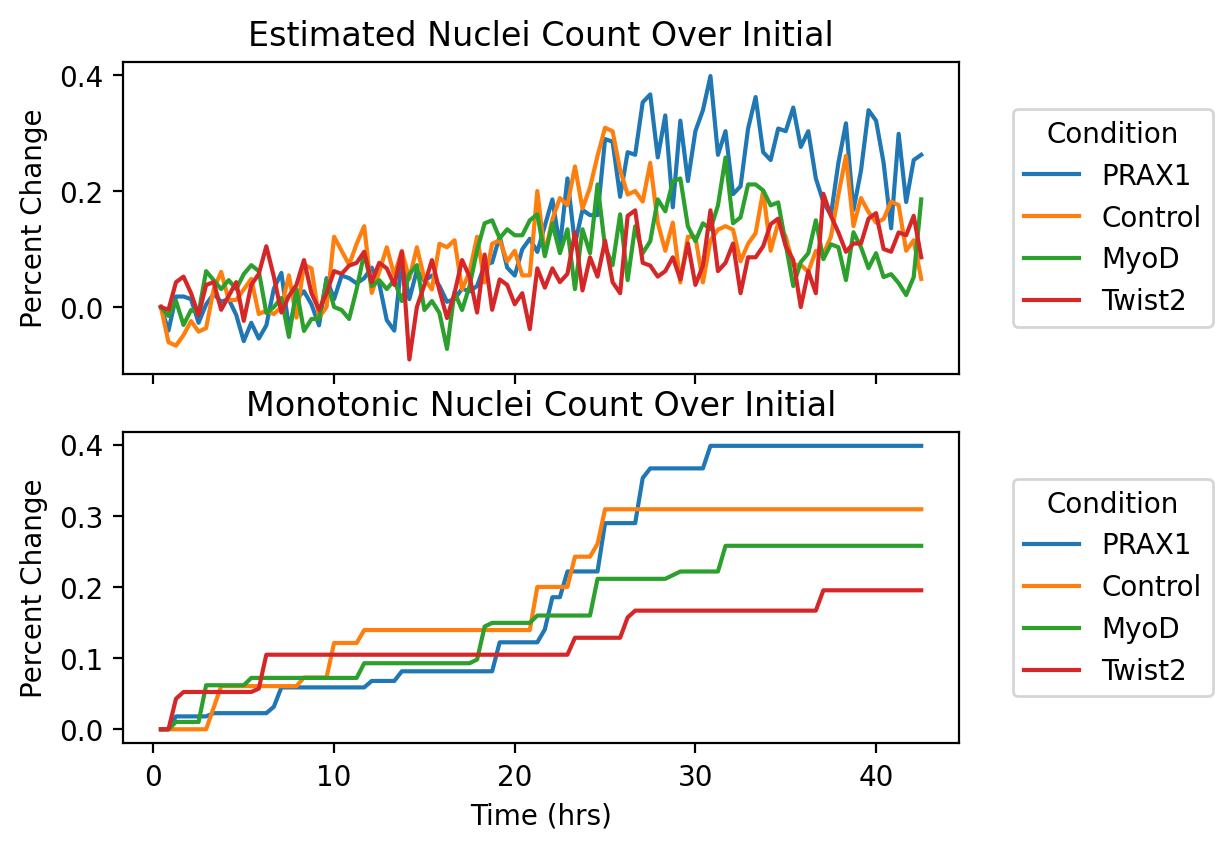

In [5]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 4

fig, axs = plt.subplots(2, sharex=True)
fig.tight_layout()
sns.lineplot(data=df,
             x='Time',
             y='Normalized Count',
             hue='Condition',
             ax=axs[0])

axs[0].set_title("Estimated Nuclei Count Over Initial")
axs[0].set_ylabel("Percent Change")
axs[0].legend(title='Condition', bbox_to_anchor=(1.32, 0.5), loc=7)

sns.lineplot(data=df,
             x='Time',
             y='Normalized Monotonic Count',
             hue='Condition',
             ls='-',
             ax=axs[1])

axs[1].set_title("Monotonic Nuclei Count Over Initial")
axs[1].set_ylabel("Percent Change")
axs[1].set_xlabel("Time (hrs)")
axs[1].legend(title='Condition', bbox_to_anchor=(1.32, 0.5), loc=7)

In [6]:
res = df.groupby('Condition', as_index=False).agg(
    Initial = ('Count', np.min),
    Final = ('Count', np.max),
    MeanChange = ('mean_delta', 'first')
)

res['PercChange'] = (res['Final'] / res['Initial']) - 1

res.columns = [
    'Condition',
    'Inital Nuclei Count',
    'Final Nuclei Count',
    'Mean Nuclei Change (25m)',
    'Percent Change (48hr)',
]

print(res.round(2).to_latex(index=False))

\begin{tabular}{lrrrr}
\toprule
Condition &  Inital Nuclei Count &  Final Nuclei Count &  Mean Nuclei Change (25m) &  Percent Change (48hr) \\
\midrule
  Control &                  154 &                 216 &                      0.08 &                   0.40 \\
     MyoD &                  180 &                 244 &                      0.36 &                   0.36 \\
    PRAX1 &                  208 &                 309 &                      0.57 &                   0.49 \\
   Twist2 &                  191 &                 251 &                      0.18 &                   0.31 \\
\bottomrule
\end{tabular}



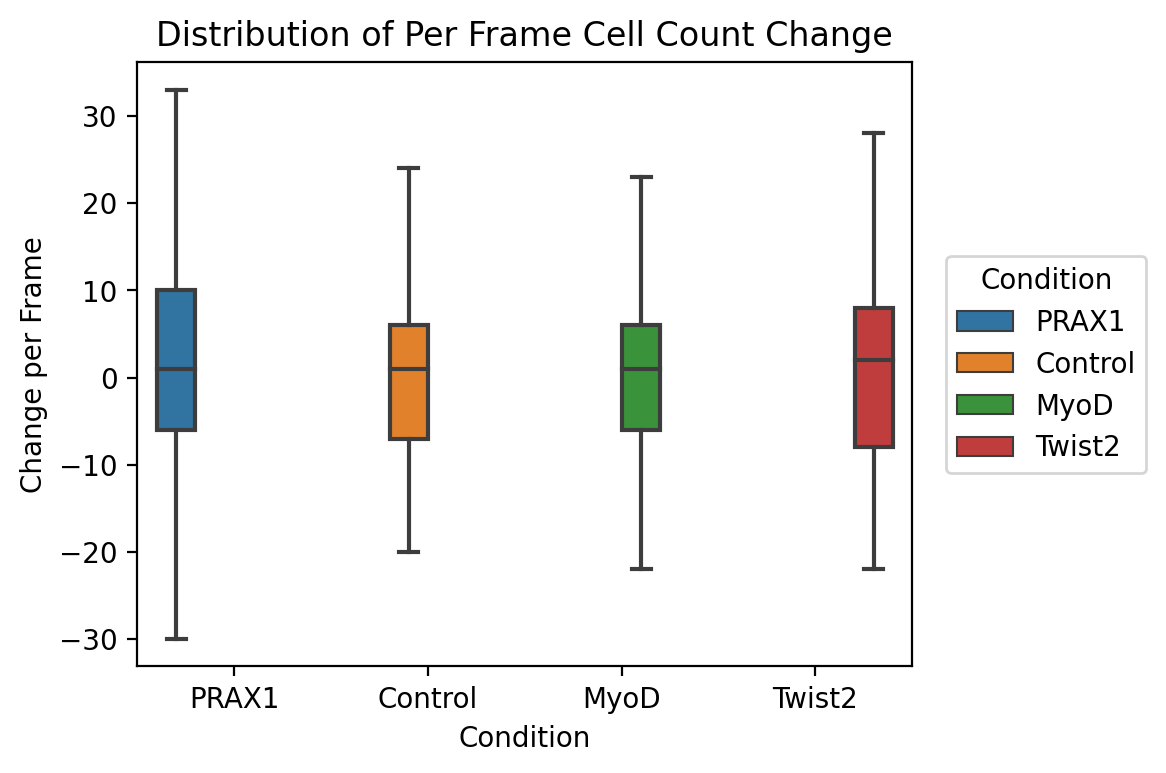

In [7]:
sns.boxplot(data=df,
            x='Condition',
            y='Delta',
            hue='Condition',
            showfliers=False)

plt.title("Distribution of Per Frame Cell Count Change")
plt.ylabel("Change per Frame")
plt.xlabel("Condition")
plt.legend(title='Condition', bbox_to_anchor=(1.32, 0.5), loc=7)

In [8]:
root_dir = "/nfs/turbo/umms-indikar/shared/projects/live_cell_imaging/6A/subset_outputs/"

experiments = {
    "B3" : "PRAX1",
    "B5" : "Control",
    "D5" : "MyoD",
    "C2" : "Twist2"
}

df_list = []

for _dir, condition in experiments.items():
    file_path = f"{root_dir}{_dir}/Cell Count Summary Red.csv"
    tmp = pd.read_csv(file_path)
    tmp['Scene'] = _dir
    tmp['Condition'] = condition
    tmp['Frame'] = tmp.index + 1
    tmp['Delta'] = tmp['Count'].diff()
    tmp['Channel'] = 'mCherry'
    tmp['init_count'] = tmp['Count'].min()
    tmp['Normalized Count'] = (tmp['Count'] / tmp['init_count']) - 1
    tmp['mean_delta'] = tmp['Delta'].mean()
    tmp['Normalized Delta'] =  tmp['Delta'] / tmp['mean_delta']
    tmp['Time'] = (tmp['Frame'] * 25) / 60
    df_list.append(tmp)
    
    file_path = f"{root_dir}{_dir}/Cell Count Summary Green.csv"
    tmp = pd.read_csv(file_path)
    tmp['Scene'] = _dir
    tmp['Condition'] = condition
    tmp['Frame'] = tmp.index + 1
    tmp['Delta'] = tmp['Count'].diff()
    tmp['Channel'] = 'mVenus'
    tmp['init_count'] = tmp['Count'].min()
    tmp['Normalized Count'] = (tmp['Count'] / tmp['init_count']) - 1
    tmp['mean_delta'] = tmp['Delta'].mean()
    tmp['Normalized Delta'] =  tmp['Delta'] / tmp['mean_delta']
    tmp['Time'] = (tmp['Frame'] * 25) / 60
    df_list.append(tmp)
    
    
df = pd.concat(df_list, ignore_index=True)

df.head()

,Slice,Count,Total Area,Average Size,%Area,Mean,Major,Minor,Angle,Scene,Condition,Frame,Delta,Channel,init_count,Normalized Count,mean_delta,Normalized Delta,Time
0,c:3/4 t:1/102 - B3_subset.czi #1,9,1295.985,143.998,0.127,255,17.618,9.978,103.302,B3,PRAX1,1,NaN,mCherry,9,0.000000,0.168317,NaN,0.416667
1,c:3/4 t:2/102 - B3_subset.czi #1,11,1440.529,130.957,0.141,255,15.872,10.128,106.360,B3,PRAX1,2,2.0,mCherry,9,0.222222,0.168317,11.882353,0.833333
2,c:3/4 t:3/102 - B3_subset.czi #1,11,1299.187,118.108,0.127,255,15.056,9.796,91.556,B3,PRAX1,3,0.0,mCherry,9,0.222222,0.168317,0.000000,1.250000
3,c:3/4 t:4/102 - B3_subset.czi #1,11,1550.485,140.953,0.152,255,15.758,10.801,69.983,B3,PRAX1,4,0.0,mCherry,9,0.222222,0.168317,0.000000,1.666667
4,c:3/4 t:5/102 - B3_subset.czi #1,14,1561.587,111.542,0.153,255,14.251,9.691,84.903,B3,PRAX1,5,3.0,mCherry,9,0.555556,0.168317,17.823529,2.083333


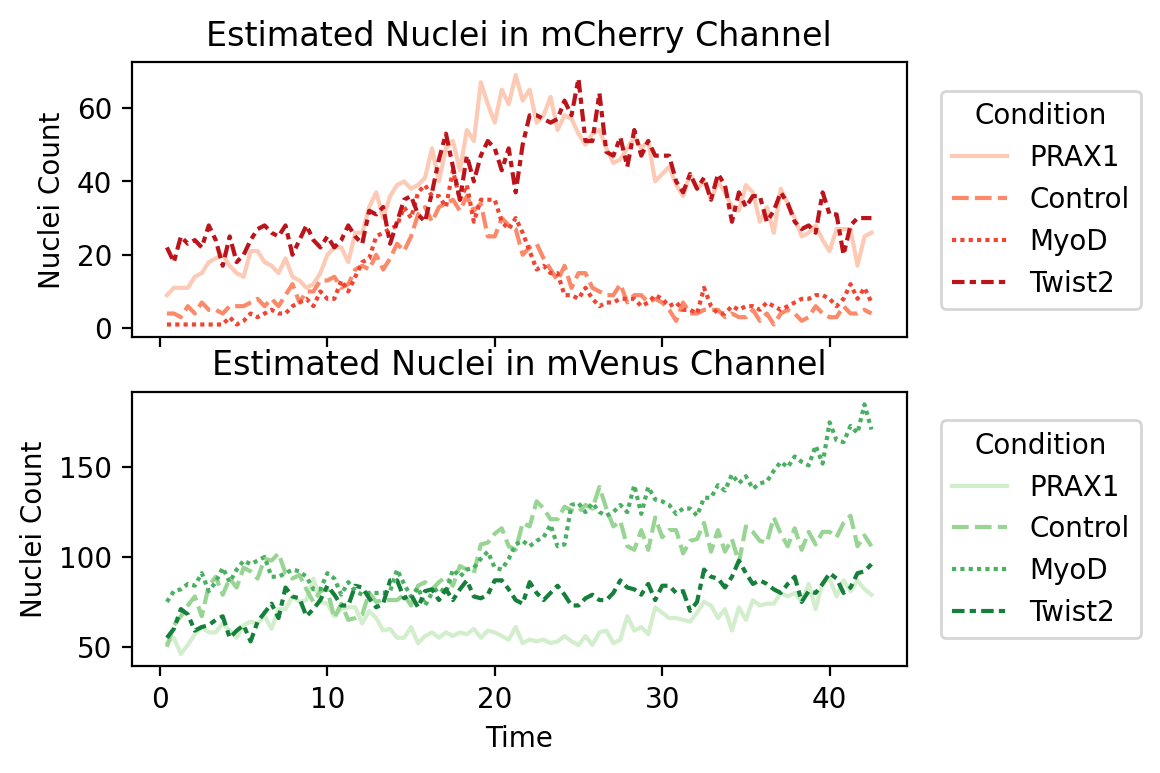

In [9]:
mCher = df[df['Channel'] == 'mCherry']
mVen = df[df['Channel'] == 'mVenus']

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 4

fig, axs = plt.subplots(2, sharex=True)

sns.lineplot(data=mCher,
             x='Time',
             y='Count',
             style='Condition',
             hue='Condition',
             palette='Reds',
             ax=axs[0])

axs[0].set_title("Estimated Nuclei in mCherry Channel")
axs[0].set_ylabel("Nuclei Count")
axs[0].legend(title='Condition', bbox_to_anchor=(1.32, 0.5), loc=7)

sns.lineplot(data=mVen,
             x='Time',
             y='Count',
             style='Condition',
             hue='Condition',
             palette='Greens',
             ax=axs[1])

axs[1].set_title("Estimated Nuclei in mVenus Channel")
axs[1].set_ylabel("Nuclei Count")
axs[1].legend(title='Condition', bbox_to_anchor=(1.32, 0.5), loc=7)

In [10]:
root_dir = "/nfs/turbo/umms-indikar/shared/projects/live_cell_imaging/6A/subset_outputs/"

experiments = {
    "B3" : "PRAX1",
    "B5" : "Control",
    "D5" : "MyoD",
    "C2" : "Twist2"
}

df_list = []

for _dir, condition in experiments.items():
    tracks_path = f"{root_dir}{_dir}/Track statistics.csv"
    tracks = pd.read_csv(tracks_path)
    
    spots_path = f"{root_dir}{_dir}/All Spots statistics.csv"
    spots = pd.read_csv(spots_path)
    
    # convert types
    spots = spots[spots['TRACK_ID'] != "None"]
    spots = spots.astype({"TRACK_ID": int})
    
    tracks = tracks.astype({"TRACK_ID": int})
    
    # merge 
    tmp = pd.merge(spots, tracks, how='left', on=['TRACK_ID'])
    
    # sort by ID then FRAME
    tmp = tmp.sort_values(by=['TRACK_ID', 'FRAME'])

    # add a grouped step 
    tmp.loc[:, 'STEP'] =  tmp.groupby(['TRACK_ID']).cumcount()
    tmp.loc[:, 'NORMED_STEP'] = tmp['STEP'] / tmp['TRACK_DURATION']
    
    tmp['Scene'] = _dir
    tmp['Condition'] = condition
    tmp['Time'] = (tmp['FRAME'] * 25) / 60
    
    tmp['TRACK_ID'] = tmp['TRACK_ID'].astype(str) + "_" + str(_dir)
    df_list.append(tmp)
    
    
df = pd.concat(df_list, ignore_index=True)

df.head()

,Label_x,ID,TRACK_ID,QUALITY,POSITION_X,POSITION_Y,POSITION_Z,POSITION_T,FRAME,RADIUS,...,LINEARITY_OF_FORWARD_PROGRESSION,MEAN_DIRECTIONAL_CHANGE_RATE,TOTAL_ABSOLUTE_ANGLE_XY,TOTAL_ABSOLUTE_ANGLE_YZ,TOTAL_ABSOLUTE_ANGLE_ZX,STEP,NORMED_STEP,Scene,Condition,Time
0,ID1727,1727,0_B3,1.724,1009.348,168.416,0,0.000,0,9,...,0.677,NaN,-1.439,3.142,1.571,0,0.000000,B3,PRAX1,0.000000
1,ID2901,2901,0_B3,1.838,998.056,172.552,0,1500.003,1,9,...,0.677,NaN,-1.439,3.142,1.571,1,0.000067,B3,PRAX1,0.416667
2,ID3475,3475,0_B3,1.793,997.516,167.382,0,3000.006,2,9,...,0.677,NaN,-1.439,3.142,1.571,2,0.000133,B3,PRAX1,0.833333
3,ID4070,4070,0_B3,1.610,995.881,162.053,0,4500.009,3,9,...,0.677,NaN,-1.439,3.142,1.571,3,0.000200,B3,PRAX1,1.250000
4,ID3275,3275,0_B3,1.622,994.076,153.583,0,7500.015,5,9,...,0.677,NaN,-1.439,3.142,1.571,4,0.000267,B3,PRAX1,2.083333


In [11]:
df.columns

Index(['Label_x', 'ID', 'TRACK_ID', 'QUALITY', 'POSITION_X', 'POSITION_Y',
       'POSITION_Z', 'POSITION_T', 'FRAME', 'RADIUS', 'VISIBILITY',
       'CELL_DIVISION_TIME', 'MEAN_INTENSITY01', 'MEAN_INTENSITY02',
       'MEAN_INTENSITY03', 'MEAN_INTENSITY04', 'MEAN_INTENSITY05',
       'MEAN_INTENSITY06', 'MEAN_INTENSITY07', 'MEAN_INTENSITY08',
       'MEAN_INTENSITY09', 'MEAN_INTENSITY10', 'MANUAL_COLOR',
       'MEAN_INTENSITY', 'MEDIAN_INTENSITY', 'MIN_INTENSITY', 'MAX_INTENSITY',
       'TOTAL_INTENSITY', 'STANDARD_DEVIATION', 'ESTIMATED_DIAMETER',
       'CONTRAST', 'SNR', 'Label_y', 'DIVISION_TIME_MEAN', 'DIVISION_TIME_STD',
       'MEAN_TRACK_INTENSITY01', 'MEAN_TRACK_INTENSITY02',
       'MEAN_TRACK_INTENSITY03', 'MEAN_TRACK_INTENSITY04',
       'MEAN_TRACK_INTENSITY05', 'MEAN_TRACK_INTENSITY06',
       'MEAN_TRACK_INTENSITY07', 'MEAN_TRACK_INTENSITY08',
       'MEAN_TRACK_INTENSITY09', 'MEAN_TRACK_INTENSITY10', 'NUMBER_SPOTS',
       'NUMBER_GAPS', 'LONGEST_GAP', 'NUMBER_SPLITS

In [12]:
# subset the columns to make processing easier

cols = [
    'TRACK_ID', 
    'QUALITY', 
    'SNR',
    'POSITION_X',
    'POSITION_Y',
    'FRAME', 
    'Time',
    'STEP',
    'NORMED_STEP',
    'RADIUS',
    'MEAN_INTENSITY01', 
    'MEAN_INTENSITY02',
    'MEAN_INTENSITY03',
    'MEAN_TRACK_INTENSITY01',
    'MEAN_TRACK_INTENSITY02',
    'MEAN_TRACK_INTENSITY03',
    'TOTAL_DISTANCE_TRAVELED',
    'TRACK_DURATION',
    'Scene',
    'Condition'
]

df = df[cols]

df.head()

,TRACK_ID,QUALITY,SNR,POSITION_X,POSITION_Y,FRAME,Time,STEP,NORMED_STEP,RADIUS,MEAN_INTENSITY01,MEAN_INTENSITY02,MEAN_INTENSITY03,MEAN_TRACK_INTENSITY01,MEAN_TRACK_INTENSITY02,MEAN_TRACK_INTENSITY03,TOTAL_DISTANCE_TRAVELED,TRACK_DURATION,Scene,Condition
0,0_B3,1.724,1.435,1009.348,168.416,0,0.000000,0,0.000000,9,0.0,0.0,177.196,1.282,0.0,186.622,82.449,15000.03,B3,PRAX1
1,0_B3,1.838,1.676,998.056,172.552,1,0.416667,1,0.000067,9,0.0,0.0,188.738,1.282,0.0,186.622,82.449,15000.03,B3,PRAX1
2,0_B3,1.793,1.666,997.516,167.382,2,0.833333,2,0.000133,9,0.0,0.0,188.738,1.282,0.0,186.622,82.449,15000.03,B3,PRAX1
3,0_B3,1.610,1.326,995.881,162.053,3,1.250000,3,0.000200,9,0.0,0.0,178.265,1.282,0.0,186.622,82.449,15000.03,B3,PRAX1
4,0_B3,1.622,1.408,994.076,153.583,5,2.083333,4,0.000267,9,0.0,0.0,184.891,1.282,0.0,186.622,82.449,15000.03,B3,PRAX1


In [13]:
# normalize the intensities

df['mCherry'] = df['MEAN_INTENSITY01'] / 255
df['mVenus'] = df['MEAN_INTENSITY02']  / 255
df['H2B'] = df['MEAN_INTENSITY03']  / 255
df['track_mCherry'] = df['MEAN_TRACK_INTENSITY01']  / 255
df['track_mVenus'] = df['MEAN_TRACK_INTENSITY02']  / 255
df['track_H2B'] = df['MEAN_TRACK_INTENSITY03']  / 255

df['ANY_mCherry'] = np.where(df['mCherry'] > 0, 1, 0)
df['ANY_mVenus'] = np.where(df['mVenus'] > 0, 1, 0)
df['ANY_H2B'] = np.where(df['H2B'] > 0, 1, 0)

In [14]:
# exclude tracks with no positive PF signal

df['has_mCherry'] = df.groupby(['TRACK_ID', 'Condition'])['ANY_mCherry'].transform(np.max)
df['has_mVenus'] = df.groupby(['TRACK_ID', 'Condition'])['ANY_mVenus'].transform(np.max)
df['has_H2B'] = df.groupby(['TRACK_ID', 'Condition'])['ANY_H2B'].transform(np.max)


In [15]:
print(df.shape)
print(df['TRACK_ID'].nunique())

tmp = df[['TRACK_ID', 'Condition']].drop_duplicates()
tmp = pd.DataFrame(tmp['Condition'].value_counts(normalize=True)).reset_index()
tmp.columns = ['Conditition', 'Percent of Total']

print(tmp.to_latex())


QUALITY_THRESHOLD = 1.75
MIN_MAX_STEP = 29

# filter for positive PF signal
df = df[df['has_mVenus'] == 1]
df = df[df['has_mCherry'] == 1]

# create mean track quality and SNR measures
df['mean_quality'] = df.groupby(['TRACK_ID'])['QUALITY'].transform(np.mean)
df['max_step'] = df.groupby(['TRACK_ID'])['STEP'].transform(np.max)


df = df[df['mean_quality'] > QUALITY_THRESHOLD]
df = df[df['max_step'] > MIN_MAX_STEP]


print(df.shape)
print(df['TRACK_ID'].nunique())

tmp = df[['TRACK_ID', 'Condition']].drop_duplicates()
tmp = pd.DataFrame(tmp['Condition'].value_counts(normalize=True)).reset_index()
tmp.columns = ['Conditition', 'Percent of Total']

print(tmp.to_latex())

(79548, 32)
6059
\begin{tabular}{llr}
\toprule
{} & Conditition &  Percent of Total \\
\midrule
0 &       PRAX1 &          0.321010 \\
1 &      Twist2 &          0.262089 \\
2 &     Control &          0.218848 \\
3 &        MyoD &          0.198052 \\
\bottomrule
\end{tabular}

(22654, 34)
446
\begin{tabular}{llr}
\toprule
{} & Conditition &  Percent of Total \\
\midrule
0 &     Control &          0.320628 \\
1 &        MyoD &          0.298206 \\
2 &      Twist2 &          0.213004 \\
3 &       PRAX1 &          0.168161 \\
\bottomrule
\end{tabular}



Text(0, 0.5, 'Median mCherry Signal')

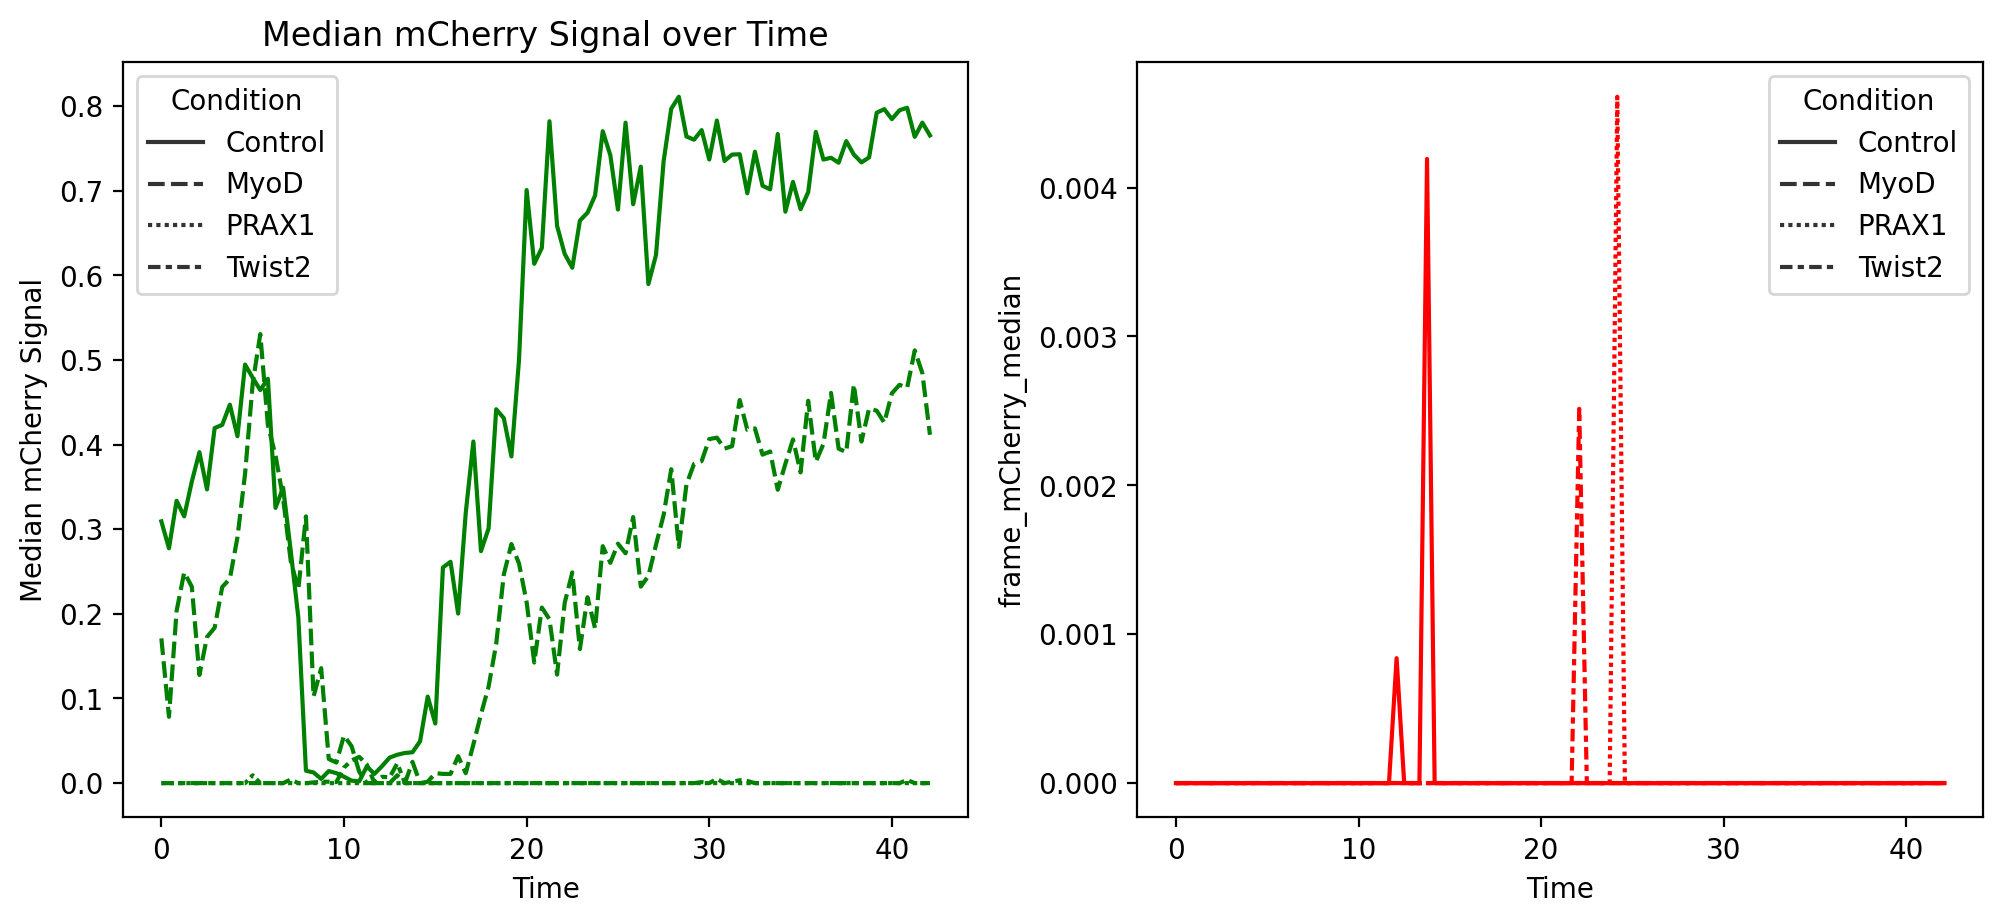

In [16]:
first_guess = []


# frame-based normalization factors
grped = df.groupby(['Time', 'Condition'], as_index=False).agg(
    frame_mCherry_mean = ('mCherry', np.mean),
    frame_mCherry_std = ('mCherry', np.std),
    frame_mCherry_median = ('mCherry', np.median),
    frame_mVenus_mean = ('mVenus', np.mean),
    frame_mVenus_std = ('mVenus', np.std),
    frame_mVenus_median = ('mVenus', np.median),
)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 12, 5

fig, axs = plt.subplots(1, 2)

sns.lineplot(data=grped,
             x='Time',
             y='frame_mVenus_median',
             style='Condition',
             color='Green',
             ax=axs[0])

axs[0].set_title("Median mVenus Signal over Time")
axs[0].set_ylabel("Median mVenus Signal")

sns.lineplot(data=grped,
             x='Time',
             y='frame_mCherry_median',
             style='Condition',
             color='Red', 
             ax=axs[1])

axs[0].set_title("Median mCherry Signal over Time")
axs[0].set_ylabel("Median mCherry Signal")

In [17]:
df = pd.merge(df, grped, on=['Time', 'Condition'], how='left')

df['mVenus_BINARY'] = np.where(df['mVenus'] > df['frame_mVenus_median'], 1, 0)
df['mCherry_BINARY'] = np.where(df['mCherry'] > df['frame_mCherry_median'], 1, 0)


# decision rules
df['state_guess'] = np.where((df['mVenus_BINARY'] == 1) & (df['mCherry_BINARY'] == 1 ), 'G2/M', 'G1')

df['state_guess'] = np.where((df['mVenus_BINARY'] == 0) & (df['mCherry_BINARY'] == 1 ), 'S', df['state_guess'])


print(df['state_guess'].value_counts(dropna=False))


G1      16416
S        3386
G2/M     2852
Name: state_guess, dtype: int64


In [18]:
transitions = {
    "G1" : "S",
    "S" : "G2/M",
    "G2/M" : "G1",
}


state_dfs = []

for tid in df['TRACK_ID'].sample(2):
    print(tid)
    
    tmp = df[df['TRACK_ID'] == tid].sort_values(by=['TRACK_ID', 'FRAME'])
    
    states = tmp['state_guess'].to_list()
    
    print(states)
    
    for i, s in enumerate(states):
        if i > 0:
            prev_state = states[i - 1]
            curr_state = states[i]
            
            if not curr_state == transitions[prev_state]:
                states[i] = prev_state
            
    print()
    print(states)
    break


112_B3
['G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G2/M', 'G2/M', 'G2/M', 'G2/M', 'G2/M', 'G2/M', 'G2/M', 'G2/M', 'G2/M', 'G2/M', 'G2/M', 'S', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1']

['G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'G1', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S']


In [19]:
y = pd.get_dummies(df['state_guess'])
df = df.join(y)
df.head()

,TRACK_ID,QUALITY,SNR,POSITION_X,POSITION_Y,FRAME,Time,STEP,NORMED_STEP,RADIUS,...,frame_mCherry_median,frame_mVenus_mean,frame_mVenus_std,frame_mVenus_median,mVenus_BINARY,mCherry_BINARY,state_guess,G1,G2/M,S
0,10_B3,1.851,2.651,1036.329,164.198,0,0.000000,0,0.000000,9,...,0.0,0.104450,0.209794,0.0,1,1,G2/M,0,1,0
1,10_B3,1.814,2.024,1037.155,167.905,1,0.416667,1,0.000015,9,...,0.0,0.108724,0.207858,0.0,1,1,G2/M,0,1,0
2,10_B3,1.750,1.934,1031.903,177.495,2,0.833333,2,0.000030,9,...,0.0,0.135341,0.245974,0.0,1,0,G1,1,0,0
3,10_B3,1.732,1.877,1031.392,179.730,3,1.250000,3,0.000044,9,...,0.0,0.120027,0.238784,0.0,1,0,G1,1,0,0
4,10_B3,1.736,1.920,1028.061,181.153,4,1.666667,4,0.000059,9,...,0.0,0.128993,0.245244,0.0,1,0,G1,1,0,0


In [20]:
grped = df.groupby(['Time', 'Condition'], as_index=False).agg(
    sum_G1 = ('G1', np.sum),
    sum_S = ('S', np.sum),
    sum_G2 = ('G2/M', np.sum),
)

grped.head()

,Time,Condition,sum_G1,sum_S,sum_G2
0,0.000000,Control,48,0,0
1,0.000000,MyoD,59,0,1
2,0.000000,PRAX1,18,2,3
3,0.000000,Twist2,25,4,3
4,0.416667,Control,46,2,1


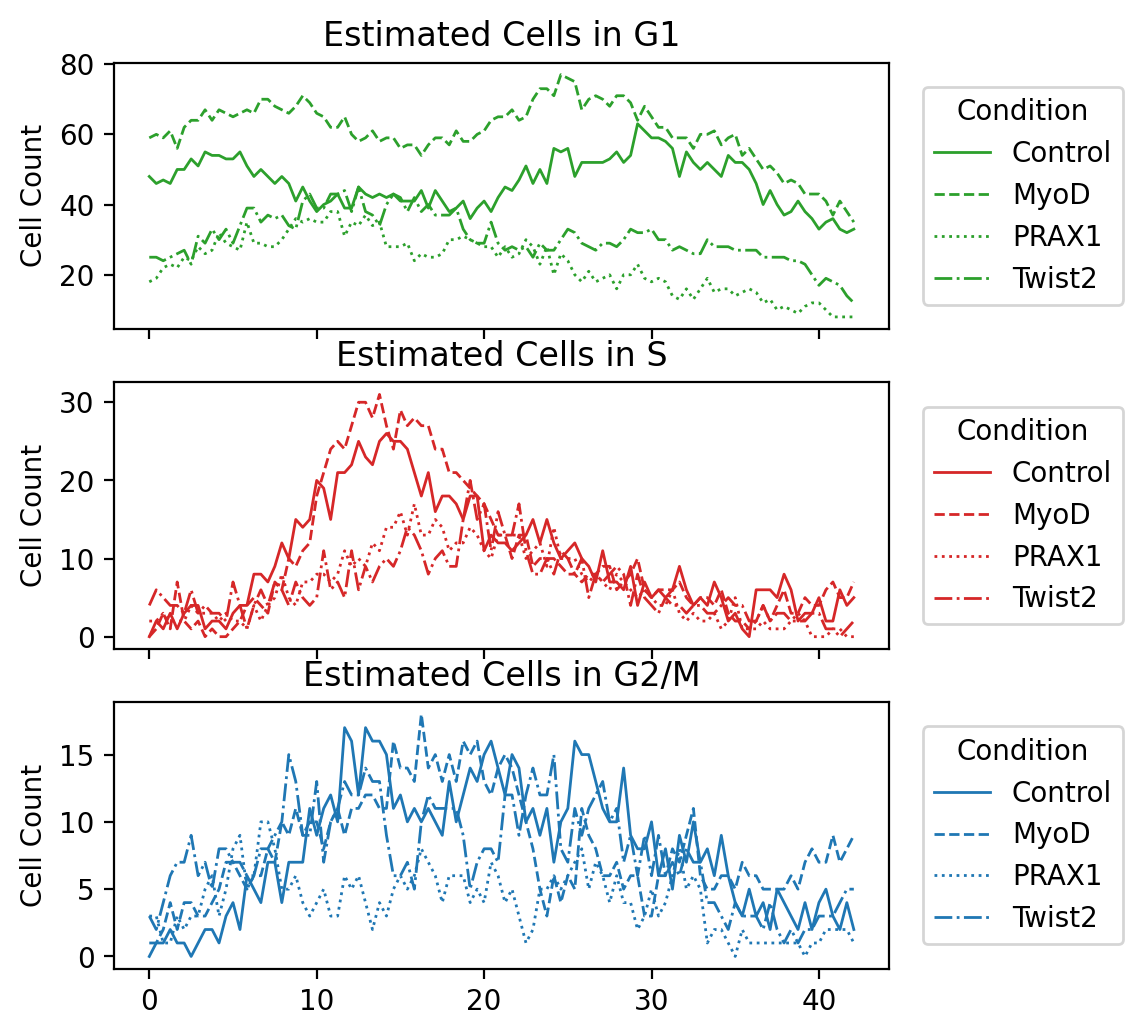

In [21]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 6

styles = {
    "PRAX1" : "dotted",
    "Control" : "solid",
    "MyoD" : "dashed",
    "Twist2" : "dashdot"
}

fig, axs = plt.subplots(3, sharex=True)

for cond in grped['Condition'].unique():
    tmp = grped[grped['Condition'] == cond]
    
    axs[0].plot(tmp['Time'], 
             tmp['sum_G1'], 
             c="C2", 
             label=cond, 
             ls=styles[cond], 
             lw=1)
    
    axs[0].set_title("Estimated Cells in G1")
    axs[0].set_ylabel("Cell Count")
    axs[0].legend(title='Condition', bbox_to_anchor=(1.32, 0.5), loc=7)
    
    axs[1].plot(tmp['Time'], 
         tmp['sum_S'], 
         c="C3", 
         label=cond, 
         ls=styles[cond], 
         lw=1)
    
    axs[1].set_title("Estimated Cells in S")
    axs[1].set_ylabel("Cell Count")
    axs[1].legend(title='Condition', bbox_to_anchor=(1.32, 0.5), loc=7)
    
    
    axs[2].plot(tmp['Time'], 
         tmp['sum_G2'], 
         c="C0", 
         label=cond, 
         ls=styles[cond], 
         lw=1)

    axs[2].set_title("Estimated Cells in G2/M")
    axs[2].set_ylabel("Cell Count")
    axs[2].legend(title='Condition', bbox_to_anchor=(1.32, 0.5), loc=7)

In [40]:
# tmp = df[['TRACK_ID', 'TOTAL_DISTANCE_TRAVELED', 'Condition']].drop_duplicates()

# sns.boxplot(data=tmp,
#             x='Condition',
#             y='TOTAL_DISTANCE_TRAVELED',
#             hue='Condition',
#             showfliers=False)

# plt.title("Distribution of Per Frame Cell Count Change")
# plt.ylabel("Change per Frame")
# plt.xlabel("Condition")
# plt.legend(title='Condition', bbox_to_anchor=(1.32, 0.5), loc=7)
